In [1]:
import numpy as np
import pandas as pd
import os
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from build_graph_data import *
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import torch


In [2]:
partition = 100

# 1. Load Dataset

In [3]:
trainpath = f'../../../data/top30groups/LongLatCombined/train1/train{partition}.csv'
testpath = f'../../../data/top30groups/LongLatCombined/test1/test{partition}.csv'
traindata = pd.read_csv(trainpath, encoding='ISO-8859-1')
testdata = pd.read_csv(testpath, encoding='ISO-8859-1')

In [4]:
combined = pd.concat([traindata, testdata], axis = 0)


In [5]:
combined['location'] = list(zip(combined['longitude'], combined['latitude']))
unique_locations = combined['location'].drop_duplicates().reset_index(drop=True)
location2id = {loc: idx for idx, loc in enumerate(unique_locations)}
num_nodes = len(location2id)
num_nodes

1790

## 2. Preprocess the Data

In [6]:
from sklearn.preprocessing import StandardScaler
coords = np.array(unique_locations.tolist())  # shape [num_nodes, 2]
scaler = StandardScaler()
features = scaler.fit_transform(coords)  # shape [num_nodes, 2]

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined['gname_encoded'] = le.fit_transform(combined['gname'])

## 3. Construct the Graph using Haversine Distance

In [7]:
from haversine import haversine, Unit

# Haversine expects (latitude, longitude), not (longitude, latitude))
coords = [(lat, lon) for lon, lat in unique_locations]

distance_threshold_km = 1
edges = []

num_nodes = len(coords)
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        dist = haversine(coords[i], coords[j], unit=Unit.KILOMETERS)
        if dist <= distance_threshold_km:
            edges.append((i, j))
            edges.append((j, i))  # undirected graph


## 4. Plot the graph

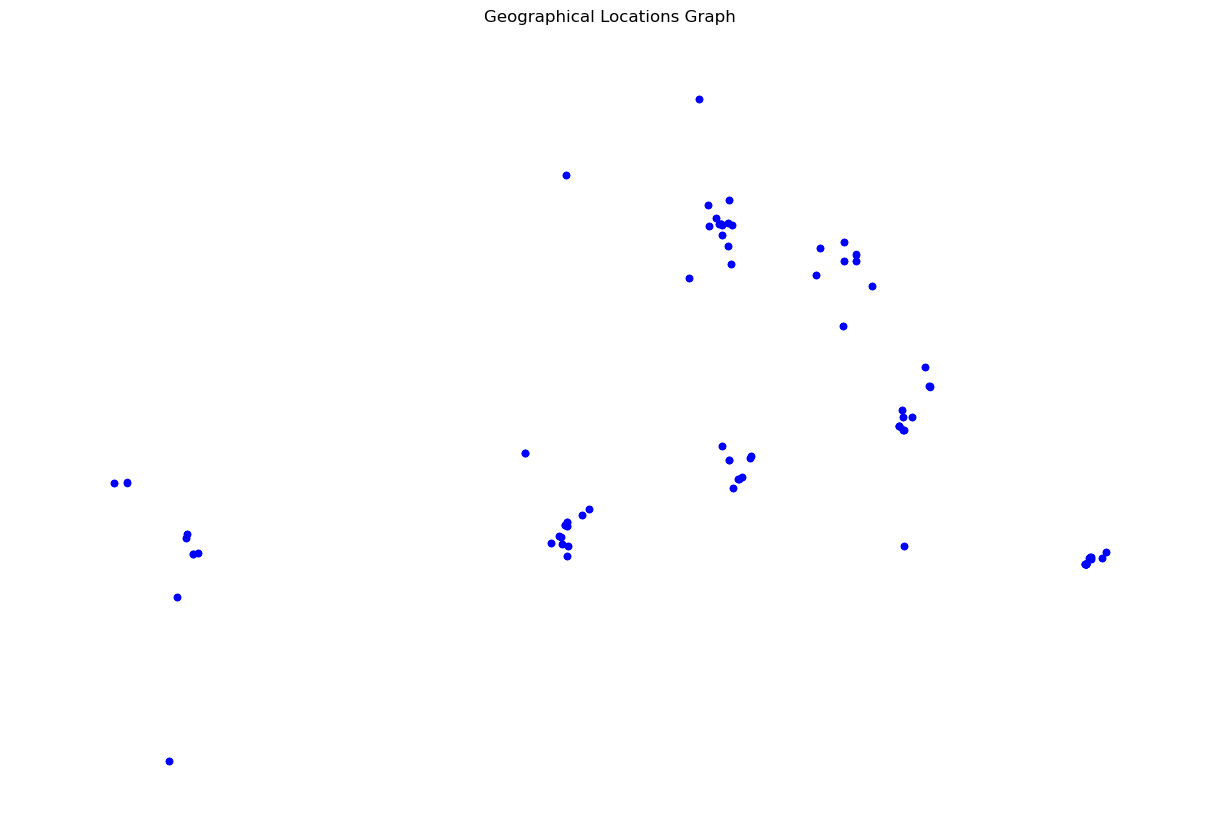

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edges)

# Use longitude for x-axis and latitude for y-axis
pos = {i: (coords[i][1], coords[i][0]) for i in range(num_nodes)}

plt.figure(figsize=(12, 8))
nx.draw(G, pos=pos, node_size=20, node_color='blue', with_labels=False)
plt.title("Geographical Locations Graph")
plt.show()


## Build train and test masks

In [9]:
y = np.full(num_nodes, -1)
train_mask = np.zeros(num_nodes, dtype=bool)
test_mask = np.zeros(num_nodes, dtype=bool)

# Get set of test locations
test_locs = set(zip(testdata['longitude'], testdata['latitude']))

# Build train_mask excluding any node that's also in the test set
for _, row in traindata.iterrows():
    loc = (row['longitude'], row['latitude'])
    if loc not in test_locs and loc in location2id:
        loc_id = location2id[loc]
        y[loc_id] = le.transform([row['gname']])[0]
        train_mask[loc_id] = True

for _, row in testdata.iterrows():
    loc = (row['longitude'], row['latitude'])
    loc_id = location2id[loc]
    y[loc_id] = le.transform([row['gname']])[0]
    test_mask[loc_id] = True

## Prepare Data for PyTorch Geometric

In [10]:
from torch_geometric.data import Data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(y, dtype=torch.long)
edge_index = torch.tensor(np.array(edges).T, dtype=torch.long)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

data = Data(x=x, edge_index=edge_index, y=y)
data = data.to(device)

/opt/conda/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


cuda


## 5. Define the GCN Model

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


model = GCN(
    in_channels=x.shape[1],
    hidden_channels=64,
    out_channels=30
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

## 6. Train the model

In [12]:
# Training function
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[train_mask], data.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function
def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out[mask].max(dim=1)[1]
        correct = pred.eq(data.y[mask]).sum().item()
        return correct / mask.size(0)

# Training loop
for epoch in range(200):
    loss = train()
    if epoch % 10 == 0:
        train_acc = test(train_mask)
        test_acc = test(test_mask)
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

# Final accuracy
print(f"Final Test Accuracy: {test(test_mask):.4f}")

Epoch 000, Loss: 3.3471, Train Acc: 0.6274, Test Acc: 0.3726
Epoch 010, Loss: 0.4500, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 020, Loss: 0.0083, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 030, Loss: 0.0008, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 040, Loss: 0.0003, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 050, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 060, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 070, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 080, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 090, Loss: 0.0002, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 100, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 110, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 120, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 130, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 140, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 150, Loss: 0.0001, Train Acc: 1.0000, Test Acc: 1.0000
Epoch 160, Loss: 0.0001,

## perfect score, check label leakage

In [14]:

train_node_ids = set(torch.where(train_mask)[0].tolist())
test_node_ids = set(torch.where(test_mask)[0].tolist())


overlap_nodes = train_node_ids & test_node_ids
print(f"Number of overlapping nodes between train and test: {len(overlap_nodes)}")


Number of overlapping nodes between train and test: 0
